In [1]:
import numpy as np
import h5py
from cvxpy import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fh5py = h5py.File('toy.hdf5', 'r')

In [3]:
X = np.array(zip(fh5py['X'][0],fh5py['X'][1]))
labels = fh5py['y']

In [4]:
labels = np.array(labels)

In [5]:
Epsilon =  Variable(len(labels))

beta = Variable(2)
beta_0 = Variable(1)

constraints = []

for i in range(0,len(labels)):
    constraints += [Epsilon[i] >= 0] + [labels[i]*(((X[i].T)*beta) + beta_0) >= (1 - Epsilon[i])]

In [6]:
S1  = [0]*len(labels)
S2  = [0]*len(labels)

for i in range(0,(len(labels))):
    if labels[i]==1:
        S1[i]=1
    else:
        S2[i]=1

## Part b : 1. 

In [7]:
C_values = [(1, 1), (1, 10), (10, 1)]

prob_values = []
beta_values = []
beta_0_values = []

C1 = Parameter(sign = "positive")
C2 = Parameter(sign = "positive")

for each in C_values:
    C1.value = each[0]
    C2.value = each[1]
    obj = Minimize(((0.5)*((norm(beta,2))**2)) + (C1*(np.array(S1).T*Epsilon)) +  (C2*(np.array(S2).T*Epsilon)) )
    prob = Problem(obj, constraints)
    prob.solve()
    prob_values.append(prob.value)
    beta_values.append((beta.value[0], beta.value[1]))
    beta_0_values.append(beta_0.value)

Below are the objective values of the optimal solution for each C_values respectively

In [8]:
prob_values

[9.604364190768385, 30.265221010022476, 11.89106364423346]

Below is the color coding for the below graphs

|   | Correct Label : +1 | Correct Label : -1 |
|---|---|---|
| Predicted : +1  |  Green | Blue  |
| Predicted : -1  |  Yellow | Red  |

## Part b : 2. 

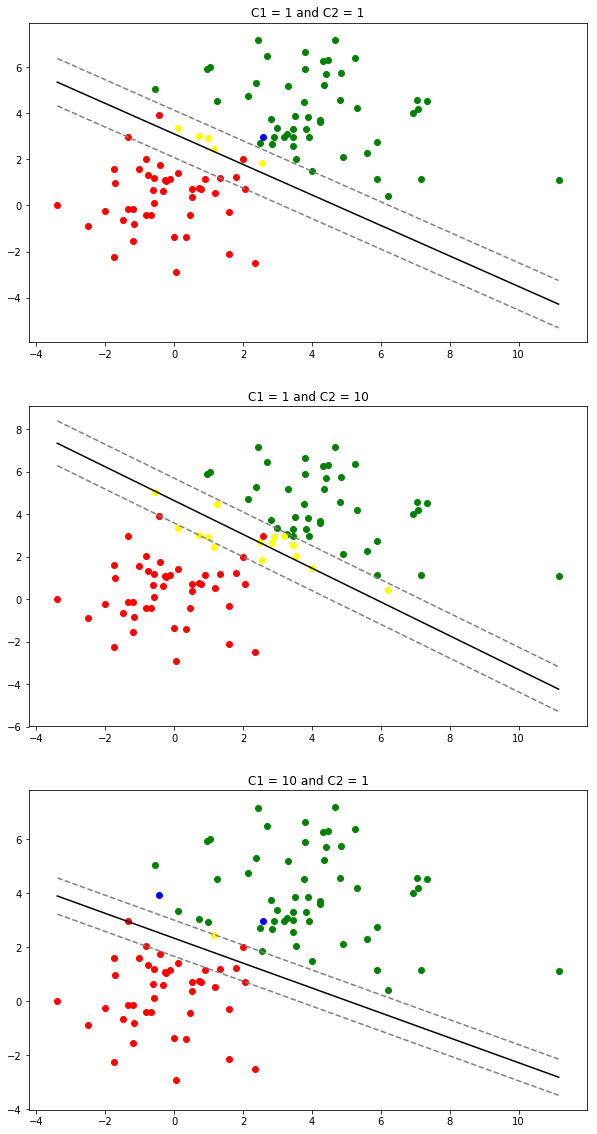

In [9]:
fig = plt.figure(figsize=(10,20))
count = 0
for k in range (0,3):
    count += 1
    
    d1min = np.min(X[:, 0])
    d1max = np.max(X[:, 0])
    
    ax = fig.add_subplot(3,1,count)
    ax.set_title('C1 = ' + str(C_values[k][0]) + ' and C2 = ' + str(C_values[k][1]))
    
    for i in range(-1,2):
        
        xx = (-beta_values[k][0]*d1min - beta_0_values[k] + i) / beta_values[k][1]
        yy = (-beta_values[k][0]*d1max - beta_0_values[k] + i) / beta_values[k][1]
        if i == 0:
            ax.plot([d1min,d1max],[xx[0,0],yy[0,0]],color='black')
        else:
            ax.plot([d1min,d1max],[xx[0,0],yy[0,0]],'--',color='gray')
    
    for i in range(0,len(X)):
        x0, y0 = d1min, xx[0,0]
        x1, y1 = d1max, yy[0,0]
        x2, y2 = X[i]
        
        N = ((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
        D = ((y2 - y1)**2 + (x2 - x1) ** 2) ** 0.5
        R = N / D
        
        if R > 0 and labels[i] < 0:
            ax.scatter(X[i][0] , X[i][1], color='red')
        elif R < 0 and labels[i] > 0:
            ax.scatter(X[i][0] , X[i][1], color='green')
        elif R < 0 and labels[i] < 0:
            ax.scatter(X[i][0] , X[i][1], color='blue')
        else:
            ax.scatter(X[i][0] , X[i][1], color='yellow')

A point is more likely to be predicted as negative, if our positive paramter has a higher penalty than the negative. Hence the decision boundary moves closer to the negative points. 

## Part b : 3 and 4

In [10]:
var_a = Variable(len(labels))

In [11]:
prob_values_2 = []
Val = Maximize(sum_entries(var_a) - 0.5 * quad_form(mul_elemwise(labels, var_a), np.dot(X,X.T)))

for each in C_values:
    constraints =[]
    C1 = each[0]
    C2 = each[1]
    for i in range(0,len(labels)):
        constraints += [var_a[i] >= 0]
        if labels[i] < 0:
            constraints += [var_a[i] <= C2]
        if labels[i] > 0:
            constraints += [var_a[i] <= C1]

    constraints += [sum_entries(labels.T * var_a)==0]
    prob = Problem(Val, constraints)
    prob.solve()
    prob_values_2.append(prob.value)

Below are the objective values of the optimal solution for each C_values respectively

In [12]:
prob_values_2

[9.60436419284549, 30.265221037327166, 11.891063691445801]

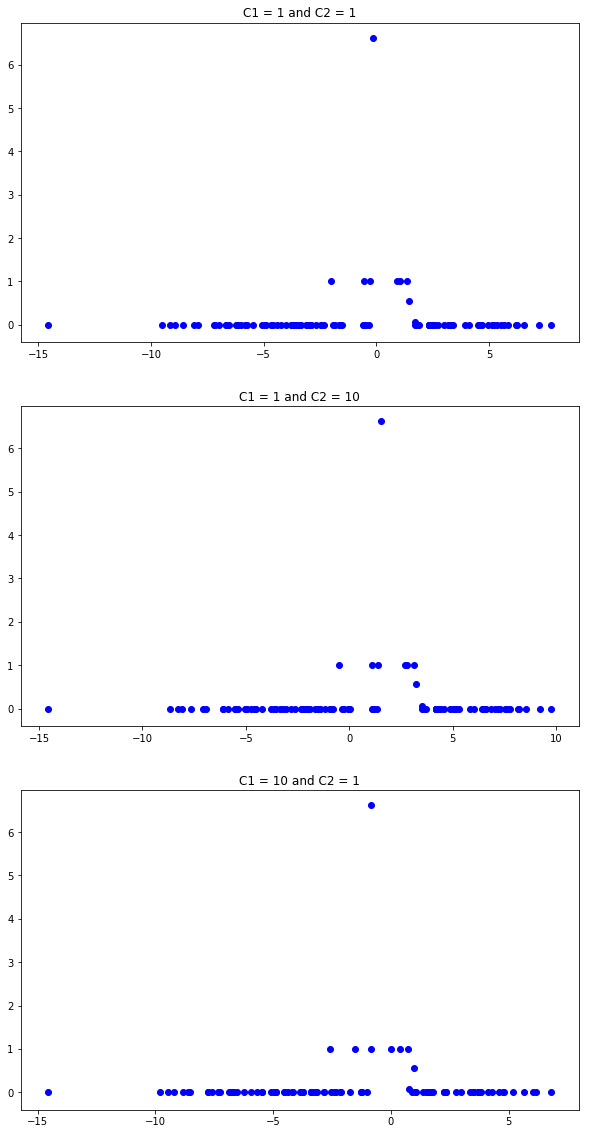

In [13]:
count = 0
fig = plt.figure(figsize=(10,20))
accuracy = []

for k in range(0,3):
    
    xx = (-beta_values[k][0]*d1min - beta_0_values[k]) / beta_values[k][1]
    yy = (-beta_values[k][0]*d1max - beta_0_values[k]) / beta_values[k][1]
    count += 1
    p = 0
    q = 0
    
    ax = fig.add_subplot(3,1,count)
    ax.set_title('C1 = ' + str(C_values[k][0]) + ' and C2 = ' + str(C_values[k][1]))
    
    for i in range(0,len(X)):
        x0, y0 = d1min, xx[0,0]
        x1, y1 = d1max, yy[0,0]
        x2, y2 = X[i]

        N = ((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
        D = ((y2 - y1)**2 + (x2 - x1) ** 2) ** 0.5
        R = N / D
        ax.scatter(R,[var_a.value[i]],color ='blue')
        
        if labels[i] < 0:
            p += C_values[k][0]
        if labels[i] > 0:
            p += C_values[k][1]
        if R > 0 and labels[i] < 0:
            q += C_values[k][0]
        if R < 0 and labels[i] > 0:
            q += C_values[k][1]
            
    accuracy.append(float(q)/p)

The accuracy values for each pair of C values

In [14]:
accuracy

[0.97, 0.8974789915966387, 0.9207920792079208]